<a href="https://colab.research.google.com/github/lfj95/SENSE2022/blob/main/solutions_training_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic segmentation of Aerial Imaginary with U-Net-like architectures**


### This notebook is a simple semantic segmentation program. The goal is to build and train a model which is able to automatically label each pixel in an aerial image with its semantic category. 

### The dataset we use consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 1305 256*256 images grouped into 6 larger tiles. The classes are: Building, Land (unpaved area), Road, Vegetation, Water, Unlabeled.

### Run on GPU

For model runtime speed, check Collab is running on GPU. 

Click the “**Runtime**” dropdown menu. Select “**Change runtime type**”. Now select '**GPU**' in the “**Hardware accelerator**” dropdown menu. 


### Install Python library
```segmentation-models```: with Neural Networks for Image Segmentation based on Keras and TensorFlow.

In [ ]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 9.4 MB/s 


### Download Dataset from GitHub
```git-clone``` - Clone a repository into a new directory

In [ ]:
!git clone https://github.com/lfj95/SENSE2022.git

Cloning into 'SENSE2022'...
remote: Enumerating objects: 2458, done.
remote: Counting objects: 100% (2458/2458), done.
remote: Compressing objects: 100% (2449/2449), done.
remote: Total 2458 (delta 14), reused 2435 (delta 6), pack-reused 0
Receiving objects: 100% (2458/2458), 44.55 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (2614/2614), done.


### Import Packages

In [ ]:
import os
import cv2
import numpy as np
import random
import pickle
from keras.models import Model
from keras.layers import *
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import plot_model


Segmentation Models: using `keras` framework.


### Set the Current Working Directory

In [ ]:
def makedir(new_dir):
  if not os.path.exists(new_dir):
    os.makedirs(new_dir)

label_directory = os.getcwd() + "/SENSE2022/split_data/labels.npy"
train_data_directory = os.getcwd() + "/SENSE2022/split_data/train/images"
valid_data_directory = os.getcwd() + "/SENSE2022/split_data/valid/images"
test_data_directory = os.getcwd() + "/SENSE2022/split_data/test/images"
save_directory = os.getcwd() + "/models"
makedir(save_directory)

### Read train/ validation/ test images from corresponding subdirectory.

In [ ]:
def read_image(path):
  image_dataset = []
  images = os.listdir(path)  #List of all image names in this subdirectory
  images = sorted(images)
  for i, image_name in enumerate(images):  
      if image_name.endswith(".jpg"):   #Only read jpg images...
          image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
          image_dataset.append(image)
  return image_dataset

X_train = np.array(read_image(train_data_directory))
X_valid = np.array(read_image(valid_data_directory))
X_test = np.array(read_image(test_data_directory))
print("Train Images size:", X_train.shape, '\n', "Validation Images size:",X_valid.shape, '\n', "Test Images size:",X_test.shape )

Train Images size: (783, 256, 256, 3) 
 Validation Images size: (261, 256, 256, 3) 
 Test Images size: (261, 256, 256, 3)


### Read array (integer values for each pixel) from .npy file,  to be used as labels. 
```
tf.keras.utils.**to_categorical**(y, num_classes=None, dtype="float32")
```
Converts a class vector (integers) to binary class matrix, e.g., for use with categorical_crossentropy.

In [ ]:
dict_load=np.load(label_directory, allow_pickle=True)

labels_train = dict_load.item()['labels_train']
labels_valid = dict_load.item()['labels_valid']
labels_test = dict_load.item()['labels_test']
n_classes = len(np.unique(labels_train))

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(labels_train, num_classes=n_classes)
y_valid = to_categorical(labels_valid, num_classes=n_classes)
y_test = to_categorical(labels_test, num_classes=n_classes)


### Define the model: U-Net based model

The model we defined consists of a contracting path and an expansive path. 
*   The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. 
*   At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. 

At the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. 

Layers used: 

1.   **Conv2D** 
```
tf.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding="valid", data_format=None, dilation_rate=(1, 1), groups=1, activation=None, use_bias=True, kernel_initializer="glorot_uniform", bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```



2.   **MaxPooling2D**
```
tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None, **kwargs)
```

3.  **UpSampling2D**
```
tf.keras.layers.UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest", **kwargs)
```
*   interpolation:	A string, one of 'nearest' or 'bilinear'.








In [ ]:
#  unet mini

num_classes=6
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# contracting path
c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
p2 = MaxPooling2D()(c2)  
  
c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

# expansive path
c4 = UpSampling2D()(c3)
c4 = concatenate([c4, c2])
c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)
c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)
  
c5 = UpSampling2D()(c4)
c5 = concatenate([c5, c1])
c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)
c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

outputs = Conv2D(num_classes, 1, activation='softmax')(c5)

model = keras.Model(inputs, outputs)

# model.summary()


### Model plotting utilities
```
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir="TB", expand_nested=False, dpi=96, layer_range=None, show_layer_activations=False)
```
Converts a Keras model to dot format and save to a file.

In [ ]:
plot_model(model, to_file= save_directory + '/small_unet1.png', show_shapes=True)

### Configures the model for training.
```
compile(optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None,jit_compile=None, **kwargs)
```


> *   optimizer:	String (name of optimizer) or optimizer instance. See tf.keras.
optimizers.
*   loss: 	Loss function. Maybe be a string (name of loss function), or a tf.keras.losses.Loss instance. See tf.keras.losses.
*   metrics: List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 







In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
metrics=['accuracy', jacard_coef]

model.compile(optimizer='adam', loss=sm.losses.CategoricalCELoss(), metrics=metrics)
# model.summary()

### Train the model for a fixed number of epochs (iterations on a dataset).

```
model.fit(x=None, y=None, batch_size=None, epochs=1, verbose="auto", callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False,)
```


> *    x: Input data. It could be either Numpy array(s) or TensorFlow tensor(s).
*    y: Target data. Like the input data x, it could be either Numpy array(s) or TensorFlow tensor(s). It should be consistent with x.
*    batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
*    epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
*    validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.
*    shuffle: Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').




In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Epoch 1/60
49/49 [==============================] - 12s 174ms/step - loss: 0.2361 - accuracy: 0.8016 - jacard_coef: 0.6102 - val_loss: 0.1012 - val_accuracy: 0.8273 - val_jacard_coef: 0.6185
Epoch 2/60
49/49 [==============================] - 7s 148ms/step - loss: 0.1001 - accuracy: 0.8185 - jacard_coef: 0.5872 - val_loss: 0.0839 - val_accuracy: 0.8528 - val_jacard_coef: 0.6449
Epoch 3/60
49/49 [==============================] - 7s 149ms/step - loss: 0.0919 - accuracy: 0.8295 - jacard_coef: 0.6043 - val_loss: 0.0791 - val_accuracy: 0.8532 - val_jacard_coef: 0.6252
Epoch 4/60
49/49 [==============================] - 7s 149ms/step - loss: 0.0832 - accuracy: 0.8412 - jacard_coef: 0.6253 - val_loss: 0.0768 - val_accuracy: 0.8555 - val_jacard_coef: 0.6437
Epoch 5/60
49/49 [==============================] - 7s 149ms/step - loss: 0.0797 - accuracy: 0.8471 - jacard_coef: 0.6316 - val_loss: 0.0741 - val_accuracy: 0.8604 - val_jacard_coef: 0.6622
Epoch 6/60
49/49 [==============================]

In [ ]:
model.save(save_directory + '/models/small_unet1.hdf5')

### Plot the training and validation accuracy and loss at each epoch

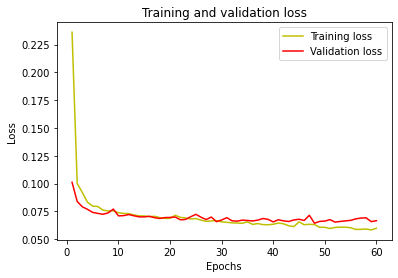

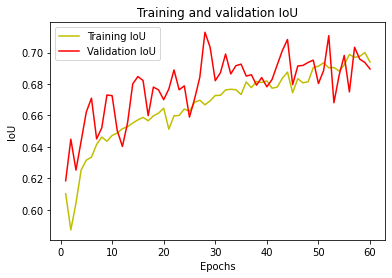

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


### Visualize predictions

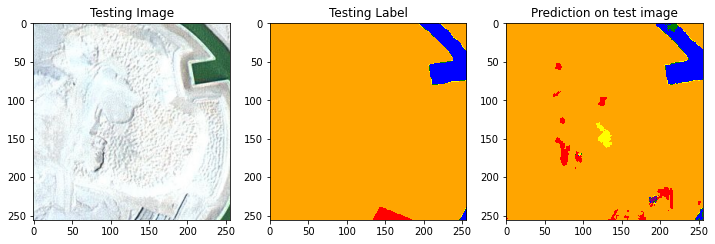

In [ ]:
from importlib import reload
# test_img_number = random.randint(0, len(X_test))
test_img_number = 20
test_img = X_test[test_img_number]
ground_truth = np.argmax(y_test, axis = 3)[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


import matplotlib as mpl 
# label == Building : 0
# label==Land : 1
# label==Road : 2
# label==Vegetation : 3
# label==Water : 4
# label==Unlabeled : 5
colors = ['red', 'orange', 'yellow', 'green','blue','purple'] 
cmap = mpl.colors.ListedColormap(colors)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, vmin=0, vmax=5, cmap=cmap)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, vmin=0, vmax=5, cmap=cmap)
plt.show()

### Exercises 1. Finetune the segmentation model 

Now try adjusting the model by implementing different methods of reducing overfitting and increasing the model's ability to generalise.









1. Retrain the model by using or adding a different loss function and see what happens to the performance of the segmentation model. The segmentation models losses can be combined together by '+' and scaled by integer or float factor set class weights for dice_loss.
E.g., add in a **categorical_crossentropy** or **CategoricalFocalLoss** loss in the Configure the model for training section.

 >Hint: Further details for loss options can be found in [segmentation losses](https://segmentation-models.readthedocs.io/en/latest/api.html?highlight=loss#losses)








 









In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

metrics=['accuracy', jacard_coef]
model.compile(optimizer='adam', loss=sm.losses.CategoricalCELoss(), metrics=metrics)


2.   In the previous model, the contracting path follows the formula: 

  `conv_layer1 -> conv_layer2 -> max_pooling` 
  
  In the expansive path, the image is going to be upsized to its original size. The formula follows:

  `conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2` 

  We built 2 contracting blocks and 2 expansive blocks. Can you repeat the bock more times? Does this improve the segmentation results?

  > Hint: Make sure the start and end image dimensions match, check the UNET structure in you’ve created small_unet1.png

In [ ]:
#  unet - 5 layers

num_classes=6
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
p2 = MaxPooling2D()(c2)
  
c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
p3 = MaxPooling2D()(c3)

c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)
p4 = MaxPooling2D()(c4)

c5 = Conv2D(256, 3, activation='relu', padding='same')(p4)
c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

c6 = UpSampling2D()(c5)
c6 = concatenate([c6, c4])
c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)
c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

c7 = UpSampling2D()(c6)
c7 = concatenate([c7, c3])
c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)
c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)


c8 = UpSampling2D()(c7)
c8 = concatenate([c8, c2])
c8 = Conv2D(32, 3, activation='relu', padding='same')(c8)
c8 = Conv2D(32, 3, activation='relu', padding='same')(c8)
  
c9 = UpSampling2D()(c8)
c9 = concatenate([c9, c1])
c9 = Conv2D(16, 3, activation='relu', padding='same')(c9)
c9 = Conv2D(16, 3, activation='relu', padding='same')(c9)

outputs = Conv2D(num_classes, 1, activation='softmax')(c9)

model = keras.Model(inputs, outputs)

# model.summary()

3.   Change the CONV layers with Batch Normalization & Dropout. 


*   One common issue in training a Segmentation model based on Deep Convolutional Neural Network for is **the internal covariate shift**, where the training of convolutional kernels is encumbered by the distribution change of input features, hence both the training speed and performance are decreased. Batch Normalization is the first proposed method for addressing internal
covariate shift and is widely used. 
*   Since **parameter size** in some Conv layers are quite large, and the training data is small. It is reasonable to add dropout between larg convolutional connections. 

  > Hint: 
  *   Keras Implementation of [Batch normalisation](https://keras.io/api/layers/normalization_layers/batch_normalization/)
  *   Keras Implementation of [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)



In [ ]:
#  unet - 5 blocks with dropout and BN

num_classes=6
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
p2 = MaxPooling2D()(c2)
  
c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
p3 = MaxPooling2D()(c3)

c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)
p4 = MaxPooling2D()(c4)

c5 = Conv2D(256, 3, activation='relu', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

c6 = UpSampling2D()(c5)
c6 = concatenate([c6, c4])
c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

c7 = UpSampling2D()(c6)
c7 = concatenate([c7, c3])
c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)


c8 = UpSampling2D()(c7)
c8 = concatenate([c8, c2])
c8 = Conv2D(32, 3, activation='relu', padding='same')(c8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.2)(c8)
c8 = Conv2D(32, 3, activation='relu', padding='same')(c8)
  
c9 = UpSampling2D()(c8)
c9 = concatenate([c9, c1])
c9 = Conv2D(16, 3, activation='relu', padding='same')(c9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(16, 3, activation='relu', padding='same')(c9)

outputs = Conv2D(num_classes, 1, activation='softmax')(c9)

model = keras.Model(inputs, outputs)

# model.summary()


In [ ]:
model.compile(optimizer='adam', loss=sm.losses.DiceLoss(), metrics=metrics)
# model.summary()

In [ ]:
history2 = model.fit(X_train, y_train,
                    batch_size = 16, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Epoch 1/60
49/49 [==============================] - 14s 278ms/step - loss: 0.5091 - accuracy: 0.7338 - jacard_coef: 0.5228 - val_loss: 0.8675 - val_accuracy: 0.2149 - val_jacard_coef: 0.1260
Epoch 2/60
49/49 [==============================] - 10s 199ms/step - loss: 0.4568 - accuracy: 0.7534 - jacard_coef: 0.5972 - val_loss: 0.5563 - val_accuracy: 0.7370 - val_jacard_coef: 0.5837
Epoch 3/60
49/49 [==============================] - 10s 200ms/step - loss: 0.4417 - accuracy: 0.7680 - jacard_coef: 0.6183 - val_loss: 0.5559 - val_accuracy: 0.7385 - val_jacard_coef: 0.5659
Epoch 4/60
49/49 [==============================] - 10s 200ms/step - loss: 0.4105 - accuracy: 0.7898 - jacard_coef: 0.6484 - val_loss: 0.4890 - val_accuracy: 0.7480 - val_jacard_coef: 0.5966
Epoch 5/60
49/49 [==============================] - 10s 201ms/step - loss: 0.4046 - accuracy: 0.7926 - jacard_coef: 0.6533 - val_loss: 0.4980 - val_accuracy: 0.7972 - val_jacard_coef: 0.6662
Epoch 6/60
49/49 [===========================

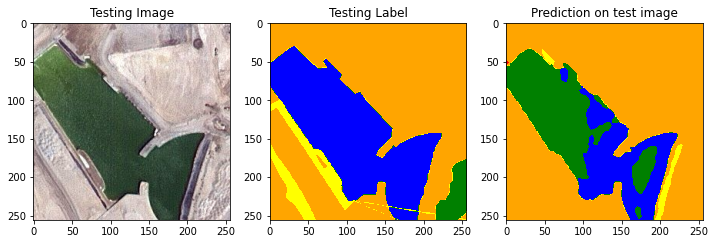

In [ ]:
from importlib import reload
# test_img_number = random.randint(0, len(X_test))
test_img_number = 0
test_img = X_test[test_img_number]
ground_truth = np.argmax(y_test, axis = 3)[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


import matplotlib as mpl 
# label == Building : 0
# label==Land : 1
# label==Road : 2
# label==Vegetation : 3
# label==Water : 4
# label==Unlabeled : 5
colors = ['red', 'orange', 'yellow', 'green','blue','purple'] 
cmap = mpl.colors.ListedColormap(colors)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, vmin=0, vmax=5, cmap=cmap)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, vmin=0, vmax=5, cmap=cmap)
plt.show()

4.   Data augmentation of your choice. 

  > Hint: **scipy.ndimage** module provides a powerful set of general, n-dimensional image processing operations. [Interpolation in scipy.ndimage](https://docs.scipy.org/doc/scipy-0.14.0/reference/ndimage.html#module-scipy.ndimage.interpolation) include basic operations like shifts, rotations and resizing as well as more general coordinate transformations like affine transforms or warping. See the following rotate example: 

  ```
scipy.ndimage.interpolation.rotate(input, angle, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)
```




In [ ]:
from scipy.ndimage.interpolation import rotate

X_tmp = rotate(X_train, 90, (1, 2))  # rotate
X_tmp = np.append(X_tmp, rotate(X_train, -90, (1, 2)), axis=0)
X_train = np.append(X_train, X_tmp, axis=0)

Y_tmp = rotate(y_train, 90, (1, 2))
Y_tmp = np.append(Y_tmp, rotate(y_train, -90, (1, 2)), axis=0)
y_train = np.append(y_train, Y_tmp, axis=0)

print("###after data augmentation###", X_train.shape, y_train.shape)
del X_tmp, Y_tmp

###after data augmentation### (3132, 256, 256, 3) (3132, 256, 256, 6)


### Exercises 2.Try another model
Change the network architecture to U-net with Resnet backbone. Use pretrainded weights to initialize it.

> Hint: To do this, follow the instructions in [Segmentation Models Python API](https://segmentation-models.readthedocs.io/en/latest/tutorial.html?highlight=loss#simple-training-pipeline), and you can implete U-net with pretrained weights in simple two lines. It provides 4 models architectures for binary and multi class segmentation (including legendary Unet) and 25 available backbones for each architecture.  All backbones have pre-trained weights for faster and better convergence.





In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)
sm.set_framework('tf.keras')

sm.framework()
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history3=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))